In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df=pd.read_csv(r'TESS.csv', comment='#' )

In [4]:
df.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


In [5]:
df = df.drop(columns=['toi', 'tid','rastr','ra','decstr','st_pmra','st_pmdec','pl_tranmid','pl_insol','pl_eqt','st_dist','toi_created','rowupdate','st_pmralim','pl_tranmidlim','pl_trandeplim','pl_trandurh','pl_trandurhlim','st_tefflim','st_distlim','st_tmaglim','st_radlim','st_pmdeclim','pl_orbperlim','pl_radelim','pl_insolerr1','pl_insolerr2','pl_insollim','pl_eqterr1','pl_eqterr2','pl_eqtlim','st_logglim'],errors='ignore')


In [6]:
mapping = {
    "CP": "Planet",
    "KP": "Planet",
    "PC": "Candidate",
    "APC": "Candidate",
    "FP": "False",
    "FA": "False"
}

df["disp_3class"] = df["tfopwg_disp"].map(mapping)
print(df["disp_3class"].value_counts())


disp_3class
Candidate    5139
False        1294
Planet       1266
Name: count, dtype: int64


In [7]:

numeric_df = df.select_dtypes(include=['float64', 'int64'])


In [16]:
from sklearn.preprocessing import StandardScaler


In [25]:
X = numeric_df
X = X.dropna(axis=1, thresh=len(X)*0.7)  
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)  

In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(le.classes_)   # ['Candidate' 'False' 'Planet']
# now y_encoded = [0, 1, 2]
from sklearn.model_selection import train_test_split



['Candidate' 'False' 'Planet']


# log transformations to stabilize distributions 

*Many features (orbital period) are highly skewed, we could reduce influence of extreme values, make distributions closer to normal.*

In [38]:
df["log_orbper"] = np.log1p(df["pl_orbper"])
df['sqrt_pl_rade']=np.sqrt(df['pl_rade']) #small rocky vs giant planets, can linearize relation with depth.
df['log_trandep'] = np.log1p(df['pl_trandep']*1e6)

# Ratios&Normalizations (instead of raw numbers)

In [39]:
df["rel_radius"] = df["pl_rade"] / df["st_rad"] #Planet radius / star radius= relative planet size
df["depth_norm"] = df["pl_trandep"] / df["st_rad"] #Transit depth / stellar radius=signal relative to star size
df['compactness'] = df['pl_orbper'] / df['st_rad'] #Orbital Compactness. Encodes how “close-in” the planet is relative to star size.

# PrincipalComponentAnalysis

*linear combinations of features that capture maximum variance, mathematical compression*
Noise reduction: Instead of keeping 50 noisy features, you keep top 5 PCs explaining ~70% variance.
Pattern detection: Sometimes clusters separate more cleanly in PC-space than raw space.
Feature compression: PCs can be added as new engineered features alongside physical ones.

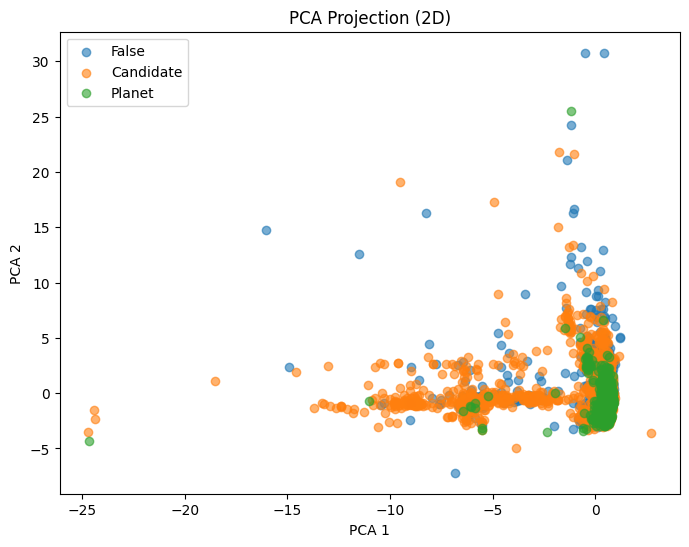

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
for i in range(5):
    df[f"pca_{i+1}"] = X_pca[:, i]


plt.figure(figsize=(8,6))
for label in y.unique():
    idx = (y == label)
    plt.scatter(df.loc[idx, "pca_1"], df.loc[idx, "pca_2"], alpha=0.6, label=label)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection (2D)")
plt.legend()
plt.show()


# Baseline Models

In [41]:
y = df["disp_3class"]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y, random_state=42
)

In [52]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

In [60]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=True,
    eval_metric="mlogloss",
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)

C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:16:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Evaluation

Cross Validation Scores

In [48]:
from sklearn.model_selection import cross_val_score

for model, name in [(logreg, "LogReg"), (rf, "RandomForest"), (xgb, "XGBoost")]:
    scores = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring="roc_auc_ovr")
    print(f"{name} ROC AUC (cv mean): {scores.mean():.3f}")


LogReg ROC AUC (cv mean): 0.713
RandomForest ROC AUC (cv mean): 0.800


C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:02:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:02:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:02:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Влада\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:02:43] WARNING: C:\actio

XGBoost ROC AUC (cv mean): 0.805


In [50]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support

*Confusion Matrix*

In [61]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Logistic Regression Confusion Matrix:\n", cm_logreg)

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:\n", cm_rf)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("XGBoost Confusion Matrix:\n", cm_xgb)


Logistic Regression Confusion Matrix:
 [[562 178 288]
 [ 70 130  59]
 [ 49  26 178]]
Random Forest Confusion Matrix:
 [[978  15  35]
 [203  55   1]
 [142   1 110]]
XGBoost Confusion Matrix:
 [[943  41  44]
 [148 105   6]
 [113   5 135]]


*ROC AUC*

In [63]:
roc_auc_logreg = roc_auc_score(y_test, y_prob_logreg, multi_class="ovr")
print(f"Logistic Regression ROC AUC: {roc_auc_logreg:.3f}")

roc_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class="ovr")
print(f"Random Forest ROC AUC: {roc_auc_rf:.3f}")

roc_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class="ovr")
print(f"Random Forest ROC AUC: {roc_auc_rf:.3f}")

Logistic Regression ROC AUC: 0.738
Random Forest ROC AUC: 0.842
Random Forest ROC AUC: 0.842


*Precision Recall F1*

In [64]:
precision_logreg, recall_logreg, f1_logreg, _ = precision_recall_fscore_support(y_test, y_pred_logreg, average="weighted")
print(f"Logistic Regression Precision: {precision_logreg:.3f}, Recall: {recall_logreg:.3f}, F1: {f1_logreg:.3f}")

precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average="weighted")
print(f"Random Forest Precision: {precision_rf:.3f}, Recall: {recall_rf:.3f}, F1: {f1_rf:.3f}")

precision_xgb, recall_xgb, f1_xgb, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average="weighted")
print(f"XGBoost Precision: {precision_xgb:.3f}, Recall: {recall_xgb:.3f}, F1: {f1_xgb:.3f}")

Logistic Regression Precision: 0.672, Recall: 0.565, F1: 0.588
Random Forest Precision: 0.748, Recall: 0.742, F1: 0.702
XGBoost Precision: 0.760, Recall: 0.768, F1: 0.751
